In [7]:
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline

from rdkit import Chem, SimDivFilters
from rdkit.Chem import rdMolDescriptors

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

import operator
import pandas as pd
import numpy as np
import math

from utils.utils import Preprocessing

In [39]:
ext_rdkit_df = pd.read_csv('./MBT_all_0910_rdkit.csv', index_col='Unnamed: 0')
ext_padel_df = pd.read_csv('./MBT_all_0910_padel.csv', index_col='Unnamed: 0')
ext_merge_df = pd.merge(ext_padel_df, ext_rdkit_df, on='ID')

ext_merge_df = ext_merge_df.drop('smiles_y', axis=1)
ext_merge_df = ext_merge_df.drop('Unnamed: 0.1', axis=1)
ext_merge_df = ext_merge_df.drop('Unnamed: 0.2', axis=1)

error_list = ['MBT-100316', 'MBT-100451', 'MBT-100537', 'MBT-100667', 'MBT-100668', 'MBT-100671', 'MBT-100672', 'MBT-100675', 'MBT-100676']

for er in error_list:
    row_ix = ext_merge_df[ext_merge_df['ID'] == er].index
    ext_merge_df = ext_merge_df.drop(row_ix[0])
    
ext_merge_df

,ID,smiles_x,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,MBT-100001,Nc1ncc(-c2nc3c(c(N4CCOCC4)n2)CCN(CC(=O)O)C3)cn1,1.0,-0.9940,0.988036,56.1435,54.028653,12.0,13.0,48.0,...,0,0,0,0,0,0,0,0,0,0
1,MBT-100002,Nc1ncc(-c2nc3c(c(N4CCOCC4)n2)CCN(CC(=O)N2CCC(C...,0.0,-2.6966,7.271652,81.6929,73.023376,12.0,13.0,66.0,...,0,0,0,0,0,0,0,0,0,0
2,MBT-100003,CC(C)c1cc(C(=O)N2Cc3ccc(CN4CCN(C(=O)CN5CCc6c(n...,0.0,-2.2771,5.185184,119.0876,117.416064,24.0,25.0,103.0,...,0,0,0,0,0,0,0,0,0,0
3,MBT-100004,CC(C)c1cc(-c2n[nH]c(=O)n2-c2ccc(CN3CCN(C(=O)CN...,0.0,-2.2932,5.258766,112.1643,116.522478,29.0,32.0,102.0,...,0,0,0,0,0,0,0,0,0,0
4,MBT-100005,CC(C)(C)OC(=O)N1CCc2c(nc(-c3cnc(N)nc3)nc2N2CCO...,0.0,0.3840,0.147456,69.7575,63.309411,12.0,13.0,57.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,MBT-100741,C=CC(=O)Nc1cc(-c2nn(C3CCC(N4CCN(C(=O)c5cnn(C6C...,0.0,-4.2773,18.295295,139.2999,162.766752,38.0,40.0,140.0,...,0,0,0,0,0,0,0,0,0,0
740,MBT-100742,C=CC(=O)Nc1cc(-c2nn(C3CCC(N4CCN(C(=O)c5cnc(OC6...,0.0,-4.4446,19.754469,138.0210,165.328752,39.0,41.0,142.0,...,0,0,0,0,0,0,0,0,0,0
741,MBT-100743,C=CC(=O)Nc1cc(-c2nn(C3CCC(N4CCN(C(=O)C5CCN(Cc6...,0.0,-4.3848,19.226471,136.6256,153.953166,33.0,35.0,133.0,...,0,0,0,0,0,0,0,0,0,0
742,MBT-100744,Cc1ccc(NC(=O)c2cc(N3CC[C@H](O)C3)cc(C(F)(F)F)c...,0.0,-1.3827,1.911859,80.3687,84.949583,18.0,18.0,74.0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
result_df = pd.read_csv('./result_MBT_data.csv', index_col='Unnamed: 0')

ext_merge_df2 = ext_merge_df.drop(437)
result_df2 = pd.concat([ext_merge_df2, result_df], ignore_index=True)

result_df2.filter(items=['ID', 'pred_logPapp'], axis=1)

""
0
1
2
3
4
5
6
7
8
9


In [40]:
rdkit_df = pd.read_csv('./data/2_1_all_rdkit_desc.csv', index_col='Unnamed: 0')
padel_df = pd.read_csv('./data/2_1_all_padel_desc.csv', index_col='Unnamed: 0')
merge_df = pd.merge(padel_df, rdkit_df, on='smiles')

merge_df = merge_df.drop('name_y', axis=1)
merge_df = merge_df.drop('logPapp_y', axis=1)
merge_df.rename(columns={'logPapp_x': 'logPapp'}, inplace=True)

merge_df

,name_x,smiles,logPapp,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1492-18-8,Nc1nc(=O)c2c([nH]1)NCC(CNc1ccc(C(=O)NC(CCC(=O)...,-1.522879,2,-4.9015,24.024702,75.8435,64.517032,6,12,...,0,0,0,0,0,0,0,0,0,0
1,Ac-Trp-Ala-Gly-Gly-Asp-Ala-NH2,CC(=O)NC(Cc1c[nH]c2ccccc12)C(=O)NC(C)C(=O)NCC(...,-1.498105,1,-5.9261,35.118661,111.6614,87.542548,9,10,...,0,0,0,0,0,0,0,0,0,0
2,Met-enkephalin,CSCCC(NC(=O)C(Cc1ccccc1)NC(=O)CNC(=O)CNC(=O)C(...,-1.380000,1,-4.3228,18.686600,93.7092,84.871755,12,12,...,1,0,0,0,0,0,0,0,0,0
3,loracarbef,NC(C(=O)NC1C(=O)N2C(C(=O)O)=C(Cl)CC[C@H]12)c1c...,-1.340000,1,-2.2666,5.137476,58.0938,47.516688,6,6,...,0,0,0,0,0,0,0,0,0,0
4,Ac-Trp-Ala-Gly-Gly-Lys-Ala-NH2,CC(=O)NC(Cc1c[nH]c2ccccc12)C(=O)NC(C)C(=O)NCC(...,-1.310000,0,-7.3234,53.632188,117.5620,95.226099,9,10,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4989,NaN,Cc1cc(C(C(=O)N2C[C@H](O)CC2C(=O)N[C@@H](C)c2cc...,-0.221849,0,0.9134,0.834300,175.8680,157.583580,32,34,...,0,0,0,0,0,1,0,1,0,0
4990,AK-2292,CN(CCCC#Cc1cccc2c1CN(C1CCC(=O)NC1=O)C2=O)C(=O)...,-0.221849,2,-1.4221,2.022368,169.6010,153.790822,26,28,...,0,0,0,0,0,1,0,1,0,0
4991,SIAIS100,O=C1CCC(N2Cc3c(SCCCCCCN4CCN(C5CCN(c6ncc(C(=O)N...,0.041393,0,-1.5311,2.344267,134.1762,130.883650,23,24,...,1,0,0,0,0,0,0,0,0,0
4992,NaN,CN(c1ccccc1CNc1nc(Nc2ccc(N3CCN(CCCCCCC(=O)NCCN...,0.681241,0,-4.4547,19.844352,141.5499,139.251822,24,24,...,0,1,0,0,0,0,0,0,0,0


In [66]:
mask2 = (merge_df.logPapp > -2) & (merge_df.logPapp < 2) 
df2 = merge_df.loc[mask2, :]

nciFps = []
for smi in df2['smiles']:
    mol = Chem.MolFromSmiles(smi)
    nciFps.append(rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, 2))
    
mmp = SimDivFilters.MaxMinPicker()
picks = mmp.LazyBitVectorPick(nciFps, len(nciFps), int(len(df2) * 0.7), seed=709)

y = df2['logPapp']
X = df2.iloc[:,3:]

X_ext = ext_merge_df.iloc[:,3:]

## Preprocessing -- already filtering file
# Remove missing value
for item in X:
    try:
        X[item].astype('float')
    except:
        X[item] = X[item].replace(r'^\s*$', np.NaN, regex=True)

X = X.dropna(axis=1).astype('float')

print('remove missing value : ', len(X.columns))

# standard deviation; SD < 0.01 
for item in X:
    if np.std(X[item]) < 0.01:
        X = X.drop(columns=item, axis=1)

print('standard deviation : ', len(X.columns))

# R2 filter; Xs vs. Y <= 0.01
Xs_y_score_dict = {}
for item in X:
    score = np.corrcoef(X[item], y)[0,1]
    if score <= 0.01:
        X = X.drop(columns=item, axis=1)
        
    else:
        Xs_y_score_dict[item] = score

print('Xs vs. Y : ', len(X.columns))

# Colinear filter; Xs vs. Xs > 0.9 
sorted_score_dict = sorted(Xs_y_score_dict.items(), key=operator.itemgetter(1), reverse=True)
sorted_list = [ i[0] for i in sorted_score_dict]

already_column = []
remove_column = []
for item1 in sorted_list:
    already_column.append(item1)    
    for item2 in sorted_list:   
        if item1 in already_column:
            continue
        
        if item2 in remove_column:
            continue
        
        if np.corrcoef(X[item1], X[item2])[0,1] > 0.9 and item1 != item2:
            print(item1, item2)
            X = X.drop(columns=item2, axis=1)
            remove_column.append(item2)

print('Colinear : ', len(X.columns))

X_ext = X_ext.filter(items=list(X.columns))

remove missing value :  1639
standard deviation :  1364
Xs vs. Y :  329
Colinear :  329


In [81]:
# index 437 -> FMF 누락되어 삭제
# X_ext = X_ext.drop(437)

print(X_ext.columns)


Index(['ALogP', 'nF', 'nCl', 'nI', 'nX', 'AATS0v', 'AATS1v', 'AATS2v',
       'AATS3v', 'AATS4v',
       ...
       'fr_ketone_Topliss', 'fr_lactone', 'fr_methoxy', 'fr_morpholine',
       'fr_nitro', 'fr_nitro_arom', 'fr_nitroso', 'fr_oxazole', 'fr_pyridine',
       'fr_term_acetylene'],
      dtype='object', length=329)


In [68]:
# # ## train_test split
X_train = X.iloc[list(picks)]
y_train = y.iloc[list(picks)]

X_test = X.loc[set(X.index) - set(list(picks))]
y_test = y.loc[set(y.index) - set(list(picks))]

/tmp/ipykernel_2587363/434128383.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_test = X.loc[set(X.index) - set(list(picks))]
/tmp/ipykernel_2587363/434128383.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  y_test = y.loc[set(y.index) - set(list(picks))]


In [43]:
estimator = ExtraTreesRegressor(random_state=709)
rfecv = RFECV(estimator, min_features_to_select=10, cv=5, scoring='neg_mean_absolute_error')

rfecv.fit(X_train, y_train)

# rfecv_df = pd.DataFrame(rfecv.cv_results_)
# name = file_name.replace('.csv', '.xlsx')
# rfecv_df.to_excel(excel_writer=name)

print( 'n features : ', rfecv.n_features_)
print( 'features : ', rfecv.get_feature_names_out)

n features :  53
features :  <bound method SelectorMixin.get_feature_names_out of RFECV(cv=5, estimator=ExtraTreesRegressor(random_state=709),
      min_features_to_select=10, scoring='neg_mean_absolute_error')>


In [77]:
X_train_fit = rfecv.transform(X_train)
X_test_fit = rfecv.transform(X_test)
X_ext_fit = rfecv.transform(X_ext)

In [44]:
gscv = LGBMRegressor(importance_type="gain", num_leaves=127, max_depth=-1, subsample=0.8, colsample_bytree=1.0)
gscv.fit(X_train_fit, y_train)
# param_grid = [{
#         "num_leaves": [127],
#         "max_depth": [-1],
#         "subsample": [0.8],
#         "colsample_bytree": [1.0]
#     }]

# gscv = GridSearchCV(estimator=model, param_grid= param_grid, scoring=['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'], cv=5, refit='neg_root_mean_squared_error', n_jobs=1, verbose=2)
# gscv.fit(X_train_fit, y_train)

# print('SVR rbf params : ', gscv.best_params_)
# print('SVR rbf score : ', gscv.best_score_)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13009
[LightGBM] [Info] Number of data points in the train set: 3460, number of used features: 53
[LightGBM] [Info] Start training from score 0.698695


LGBMRegressor(importance_type='gain', num_leaves=127, subsample=0.8)

In [60]:
column_list = list(rfecv.get_feature_names_out())
len(X_ext)

735

In [79]:
pred_y_train = gscv.predict(X_train_fit)

# model.fit(X_train_fit, y_train)
# pred_y_train = model.predict(X_train_fit)

train_r2 = r2_score(y_train, pred_y_train)
train_rmse = math.sqrt(mean_squared_error(y_train, pred_y_train))
train_mae = mean_absolute_error(y_train, pred_y_train)

print('train R2 :', train_r2, 'train RMSE :', train_rmse, 'train_MAE :', train_mae)

pred_y_test = gscv.predict(X_test_fit)
test_r2 = r2_score(y_test, pred_y_test)
test_rmse = math.sqrt(mean_squared_error(y_test, pred_y_test))
test_mae = mean_absolute_error(y_test, pred_y_test)

print('test R2 :', test_r2, 'test RMSE :', test_rmse, 'test_MAE :', test_mae)

pred_y_ext = gscv.predict(X_ext_fit)

ext_result_df = pd.DataFrame(pred_y_ext, columns=['pred_logPapp'])

ext_result_df.to_csv('./result_MBT_data.csv')
# ext_r2 = r2_score(y_ext, pred_y_ext)
# ext_rmse = math.sqrt(mean_squared_error(y_ext, pred_y_ext))
# ext_mae = mean_absolute_error(y_ext, pred_y_ext)

# print('external test R2 :', ext_r2, 'external test RMSE :', ext_rmse, 'external test_MAE :', ext_mae)

# result_list = [['rdkit_padel_merge', type(model).__name__, gscv.best_params_, train_r2, train_rmse, train_mae, test_r2, test_rmse, test_mae]]

# result_df = pd.DataFrame(result_list, columns=['data', 'model', 'parameter', 'trainR2', 'trainRMSE', 'trainMAE', 'testR2', 'testRMSE', 'testMAE'])
# result_df.to_excel('./results/LightGBM_rdkit_padel_merge.xlsx')

train R2 : 0.9927709133444553 train RMSE : 0.06495564951832529 train_MAE : 0.0436983775389042
test R2 : 0.8470003752374942 test RMSE : 0.29802087231640667 test_MAE : 0.1628273314836204


In [10]:
feature = X_test.columns[rfecv.support_]
X_test_fs = X_test[feature]

X_test_fs

,ALogP,AATS4v,ATSC1c,ATSC4c,ATSC7c,ATSC8m,ATSC3v,ATSC1e,ATSC1i,ATSC2i,...,XLogP,MinEStateIndex,qed,FpDensityMorgan1,SMR_VSA9,SlogP_VSA8,VSA_EState4,VSA_EState6,VSA_EState8,MolLogP
4,-7.3234,160.114306,-1.190892,-1.756903,-1.341549,-127.582548,-245.885220,-1.102183,-11.135620,-38.361641,...,-1.933,-5.751191,0.079804,0.955556,0.000000,10.902925,-5.774554,-26.570164,-29.152986,-2.44400
7,-6.0574,144.309849,-1.508418,-0.944840,-0.132394,-118.629710,-332.249726,-3.609002,2.128128,-22.429736,...,-4.814,-5.430828,0.146432,0.705882,0.000000,0.000000,0.000000,0.000000,-19.171402,-7.57140
14,-4.2268,158.264495,-1.017967,-1.398357,-1.115115,124.159305,-1096.844100,-0.951390,3.735256,-34.126047,...,0.925,-5.427072,0.140441,1.024390,5.749512,1.431200,-9.527626,-34.871361,-10.053742,-0.06710
22,-4.1486,156.142171,-1.163405,0.261544,-0.042377,-320.751537,-919.100237,-1.591033,15.986194,12.523921,...,-0.808,-6.610933,0.140164,1.195122,0.000000,0.000000,-27.869037,-2.336127,-20.815684,-1.51500
34,-1.8003,179.213014,-0.696665,-0.370054,0.471516,368.657193,-132.850547,-0.179440,-7.034846,-8.250281,...,4.459,-4.866054,0.179495,1.315789,5.749512,12.334125,-5.121955,-12.035457,-16.500810,4.64352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4989,0.9134,193.259795,-0.851055,-0.282289,0.246261,1217.804006,352.663802,0.073662,-21.161019,-2.704519,...,6.945,-5.393403,0.050490,1.068493,27.282549,15.441681,-12.813542,-29.186307,-67.526611,7.40608
4990,-1.4221,182.248373,-1.321211,-0.548469,-0.118760,643.632850,-1331.543770,-1.408193,-26.435509,24.612386,...,5.234,-6.649276,0.036657,1.148649,22.411944,20.657219,-23.176337,-38.288191,-43.147080,6.86190
4991,-1.5311,175.043308,-0.910458,-0.063177,0.502531,-420.968285,123.108057,-0.315499,-32.284989,34.673454,...,6.107,-5.551883,0.048309,1.048387,17.006891,11.257379,-19.350041,-24.691164,-41.690738,6.59200
4992,-4.4547,174.726219,-1.131728,0.355335,0.030850,927.594455,306.156289,-0.393614,-54.414673,61.077158,...,4.949,-6.574773,0.058555,1.000000,0.000000,0.000000,-16.779409,-25.314129,-44.978000,4.94890


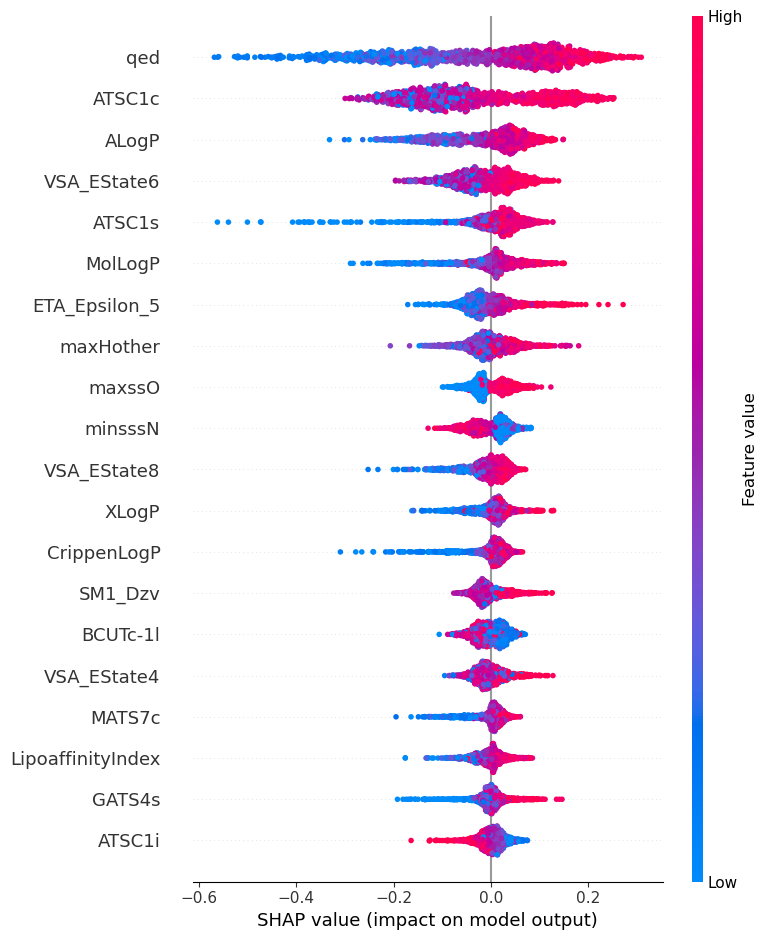

In [11]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(gscv)
shap_values = explainer.shap_values(X_test_fs)

fig = shap.summary_plot(shap_values, X_test_fs)